In [1956]:
# Load pytorch model from weights
import glob
import random

import cv2
import matplotlib.patches as patches
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt

from src.models import YOLO11
from src.utils.dataset import resize
from src.utils.loss import non_max_suppression

model = YOLO11("n", num_classes=80) # Create the model
model.load_state_dict(torch.load("weights/yolo11n.pt"))
model.eval()  # Set the model to evaluation mode


YOLO11(
  (backbone): Yolo11BackBone(
    (block0_conv1): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (block1_conv2): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (block2_c3k2_1): C3k2(
      (conv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (conv2): Conv(
        (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act

In [1957]:
DATASET_PATH = "../yolo-testing/datasets/coco8"

classes = {
    0: "person",
    1: "bicycle",
    2: "car",
    3: "motorcycle",
    4: "airplane",
    5: "bus",
    6: "train",
    7: "truck",
    8: "boat",
    9: "traffic light",
    10: "fire hydrant",
    11: "stop sign",
    12: "parking meter",
    13: "bench",
    14: "bird",
    15: "cat",
    16: "dog",
    17: "horse",
    18: "sheep",
    19: "cow",
    20: "elephant",
    21: "bear",
    22: "zebra",
    23: "giraffe",
    24: "backpack",
    25: "umbrella",
    26: "handbag",
    27: "tie",
    28: "suitcase",
    29: "frisbee",
    30: "skis",
    31: "snowboard",
    32: "sports ball",
    33: "kite",
    34: "baseball bat",
    35: "baseball glove",
    36: "skateboard",
    37: "surfboard",
    38: "tennis racket",
    39: "bottle",
    40: "wine glass",
    41: "cup",
    42: "fork",
    43: "knife",
    44: "spoon",
    45: "bowl",
    46: "banana",
    47: "apple",
    48: "sandwich",
    49: "orange",
    50: "broccoli",
    51: "carrot",
    52: "hot dog",
    53: "pizza",
    54: "donut",
    55: "cake",
    56: "chair",
    57: "couch",
    58: "potted plant",
    59: "bed",
    60: "dining table",
    61: "toilet",
    62: "tv",
    63: "laptop",
    64: "mouse",
    65: "remote",
    66: "keyboard",
    67: "cell phone",
    68: "microwave",
    69: "oven",
    70: "toaster",
    71: "sink",
    72: "refrigerator",
    73: "book",
    74: "clock",
    75: "vase",
    76: "scissors",
    77: "teddy bear",
    78: "hair drier",
    79: "toothbrush"
}

INPUT_SIZE = 640

In [1958]:
def visualize_bounding_boxes(image: np.ndarray, nms_output: torch.Tensor, class_names: list[str]) -> None:
    """
    Visualize bounding boxes on an image using Matplotlib.

    Args:
        image: The image as a NumPy array.
        nms_output: The output tensor from non_max_suppression.
        class_names: List of class names.
    """
    _, ax = plt.subplots(1, figsize=(12, 8))
    # set correct colors 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)

    for box in nms_output:
        x1, y1, x2, y2, confidence, cls = box
        width, height = x2 - x1, y2 - y1
        color = np.random.rand(3,)  # Random color for each box
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f'{class_names[int(cls)]}: {confidence:.2f}', bbox=dict(facecolor=color, alpha=0.5), fontsize=12, color='white')

    plt.axis('off')
    plt.show()

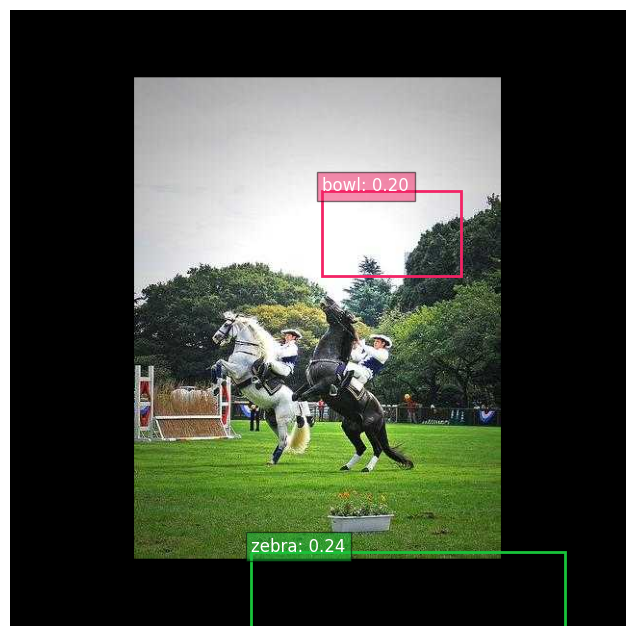

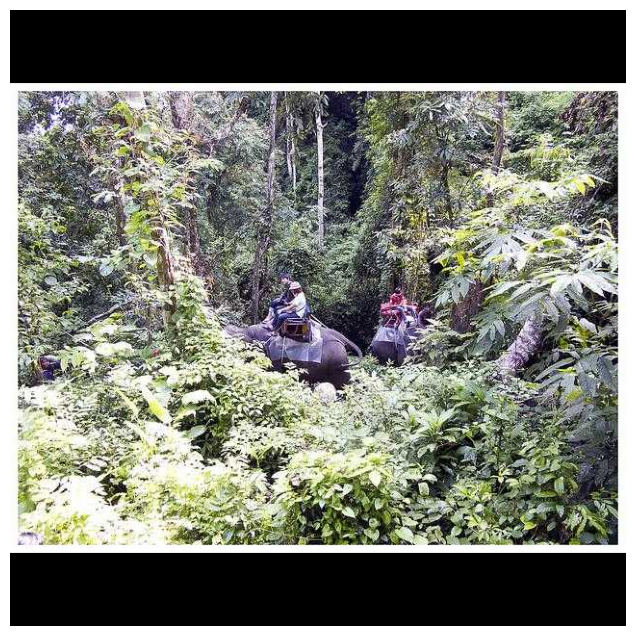

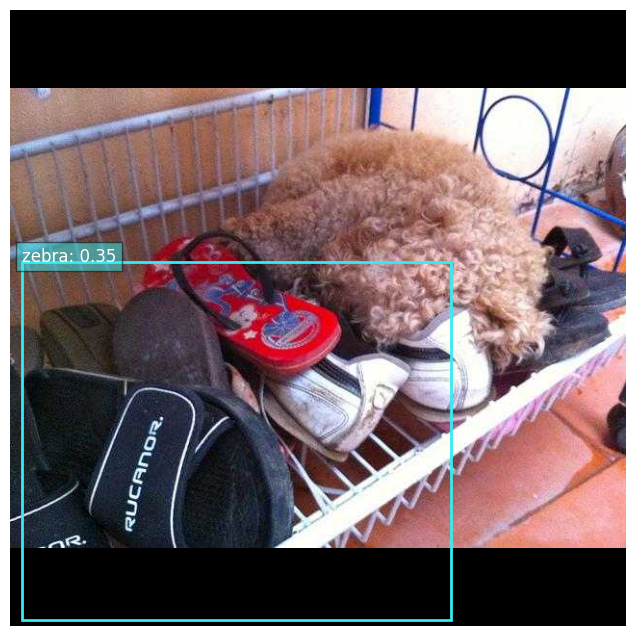

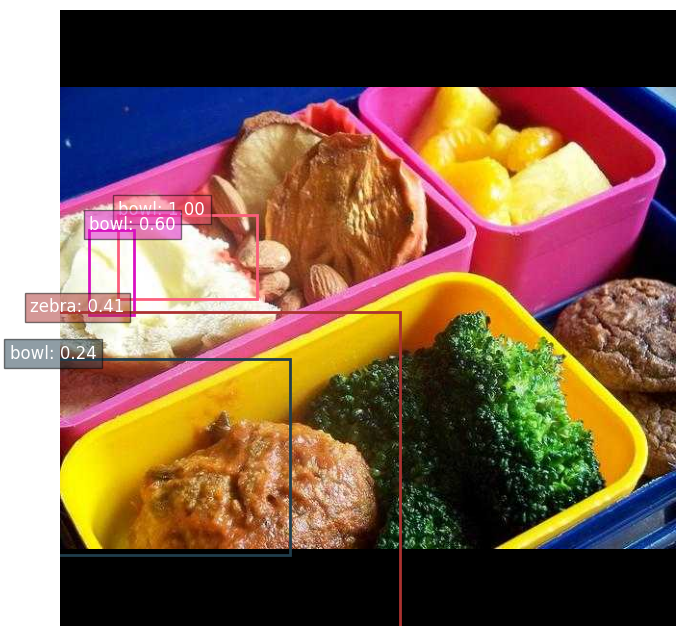

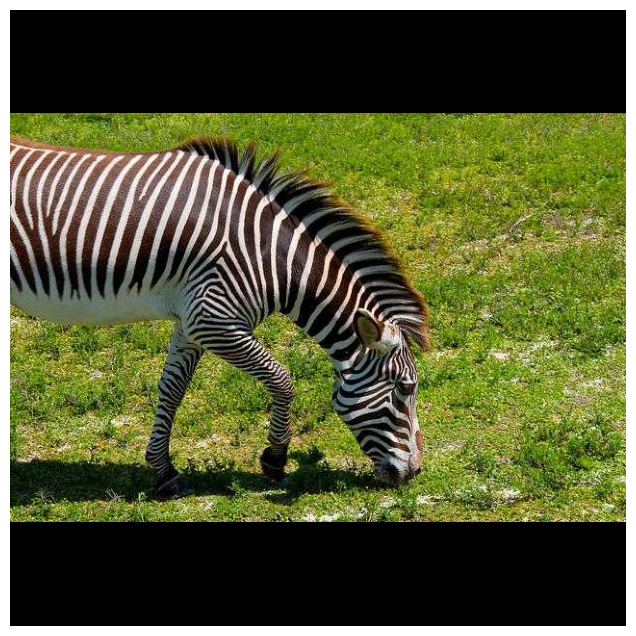

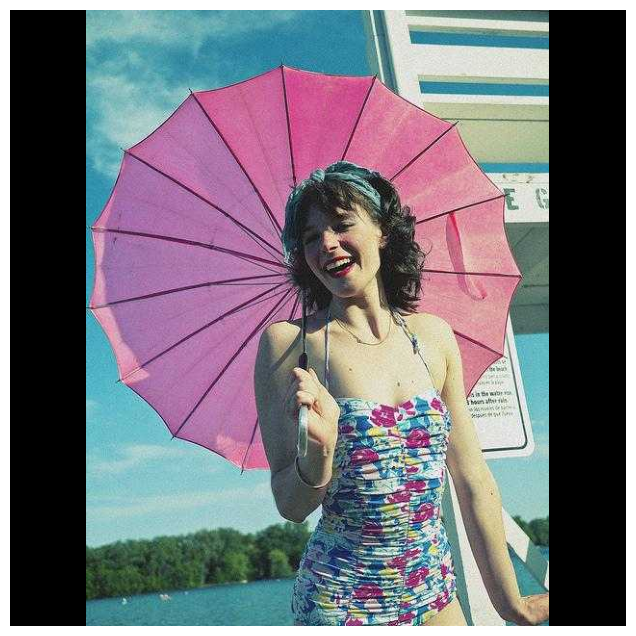

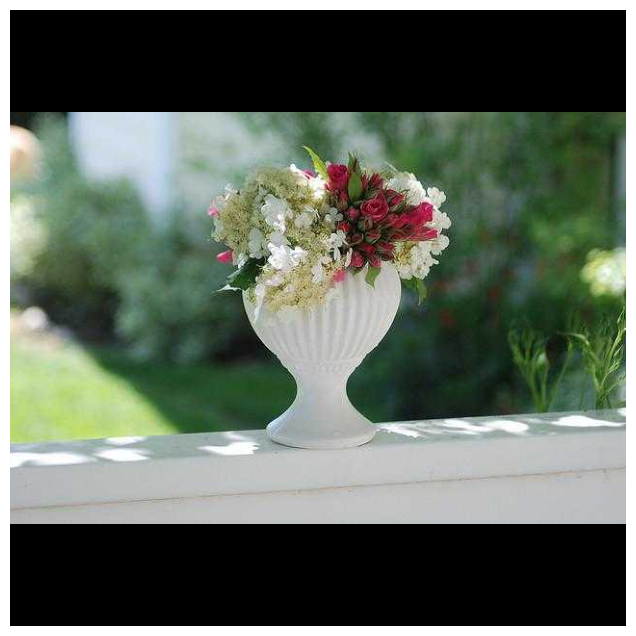

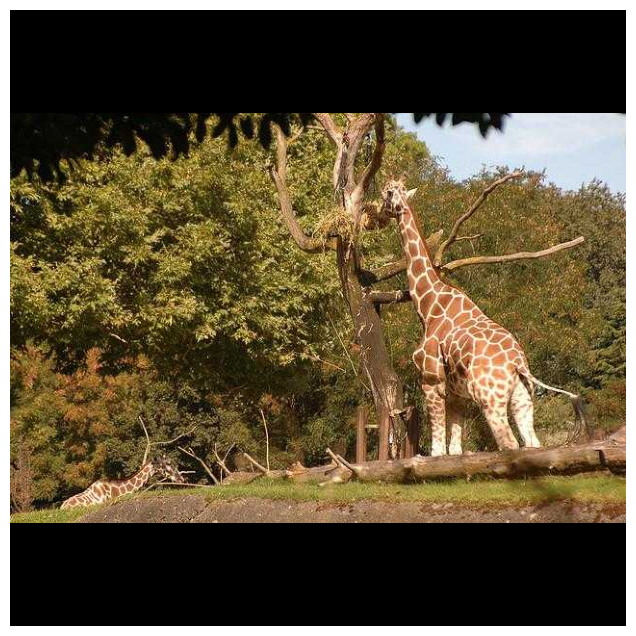

In [1959]:
training_images = glob.glob(f'{DATASET_PATH}/images/train/*.jpg')

for i in training_images:
    my_image = cv2.imread(i)
    resized_image, _, _ = resize(my_image,640, False)

    # convert the image to tensor
    image = torch.tensor(resized_image, dtype=torch.float32)

    # normalize the image
    image = image / 255.0

    # add batch dimension
    image = image.unsqueeze(0)
    image = image.permute(0, 3, 1, 2)

    predictions = None
    # run the model
    with torch.no_grad():
        predictions = model(image)

    non_max_suppression_output = non_max_suppression(predictions, 0.1, 0.1)

    visualize_bounding_boxes(resized_image, non_max_suppression_output[0], classes)